## Sagnac Frequency - Backscatter Correction - RU Longterm

## Imports

In [1]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream
from scipy.signal import hilbert

from functions.get_fft import __get_fft
from functions.multitaper_psd import __multitaper_psd
from functions.welch_psd import __welch_psd
from andbro__read_sds import __read_sds
from andbro__readYaml import __readYaml

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [ ]:
def __reduce(dat, n_samples):
    from numpy import nanmean
    return dat - nanmean(dat[:n_samples])

## Configurations

In [3]:
config = {}

config['ring'] = "U"

config['seed'] = "BW.DROMY..FJU"

config['path_to_sds'] = archive_path+"romy_archive/"

config['tbeg'] = UTCDateTime("2023-11-01 00:00")
config['tend'] = UTCDateTime("2024-01-12 00:00")


## path to Sagnac data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"sagnac_frequency/data/backscatter/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

## Configurations

In [4]:
def __load_backscatter_data(tbeg, tend, ring, path_to_data):

    from obspy import UTCDateTime
    from datetime import date
    from pandas import read_pickle, concat, DataFrame, date_range

    t1 = date.fromisoformat(str(UTCDateTime(tbeg).date))
    t2 = date.fromisoformat(str((UTCDateTime(tend)-86400).date))

    df = DataFrame()
    for dat in date_range(t1, t2):
        print(dat)
        dat_str = str(dat)[:10].replace("-","")
        file = f"FJ{ring}_{dat_str}_backscatter.pkl"

        if not os.path.isfile(path_to_data+file):
            _path = data_path+"sagnac_frequency/data/"

            out = DataFrame()
            for m in range(24):
                hour = str(m).rjust(2, '0')+":00:00"
                filename = f"FJU_{dat_str}_{hour}_backscatter.pkl"
                try:
                    _df = read_pickle(_path+filename)
                    out = concat([out, _df])
                except:
                    print(f" -> failed: {_path}{filename}")
                    continue

            if not out.empty:
                print(f" -> write to: {_path}backscatter/FJU_{dat_str}_backscatter.pkl")
                out.to_pickle(f"{_path}backscatter/FJU_{dat_str}_backscatter.pkl")
            else:
                continue

        try:
            df0 = read_pickle(path_to_data+file)
            df = concat([df, df0])
        except:
            print(f"error for {file}")

    df.reset_index(inplace=True)

    return df

In [5]:
bs = __load_backscatter_data(config['tbeg'], config['tend'], config['ring'], config['path_to_data'])

bs['time_sec'] = bs.time2 - bs.time1 + (bs.time1 - bs.time1.loc[0])

2023-11-01 00:00:00
2023-11-02 00:00:00
2023-11-03 00:00:00
2023-11-04 00:00:00
2023-11-05 00:00:00
2023-11-06 00:00:00
2023-11-07 00:00:00
2023-11-08 00:00:00
2023-11-09 00:00:00
2023-11-10 00:00:00
2023-11-11 00:00:00
2023-11-12 00:00:00
2023-11-13 00:00:00
2023-11-14 00:00:00
2023-11-15 00:00:00
2023-11-16 00:00:00
2023-11-17 00:00:00
2023-11-18 00:00:00
2023-11-19 00:00:00
2023-11-20 00:00:00
2023-11-21 00:00:00
2023-11-22 00:00:00
2023-11-23 00:00:00
2023-11-24 00:00:00
2023-11-25 00:00:00
2023-11-26 00:00:00
2023-11-27 00:00:00
2023-11-28 00:00:00
2023-11-29 00:00:00
2023-11-30 00:00:00
2023-12-01 00:00:00
2023-12-02 00:00:00
2023-12-03 00:00:00
2023-12-04 00:00:00
2023-12-05 00:00:00
2023-12-06 00:00:00
2023-12-07 00:00:00
2023-12-08 00:00:00
2023-12-09 00:00:00
2023-12-10 00:00:00
2023-12-11 00:00:00
2023-12-12 00:00:00
2023-12-13 00:00:00
2023-12-14 00:00:00
2023-12-15 00:00:00
2023-12-16 00:00:00
2023-12-17 00:00:00
2023-12-18 00:00:00
2023-12-19 00:00:00
2023-12-20 00:00:00


(302.3, 303.2)

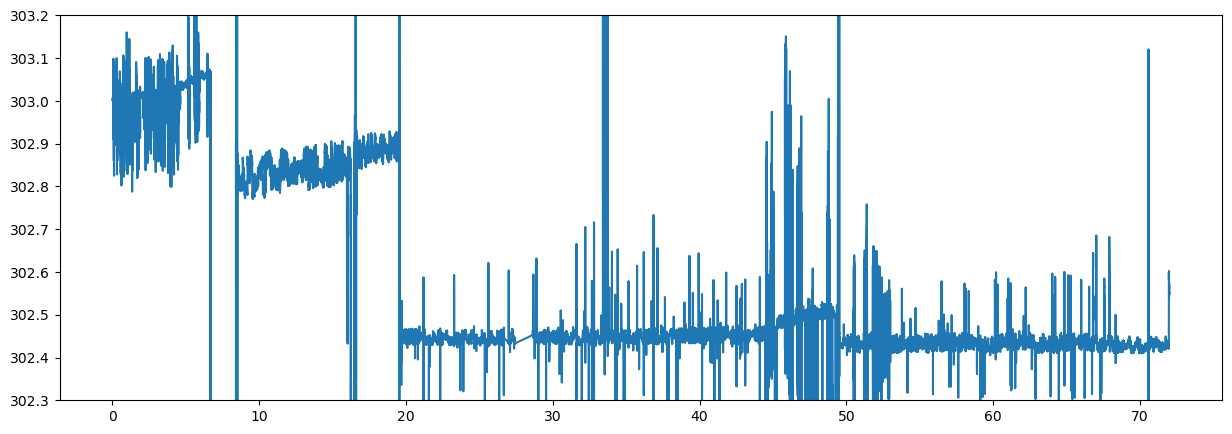

In [6]:
plt.figure(figsize=(15,5))
plt.plot(bs.time_sec/86400, bs.fj_fs)
plt.ylim(302.3, 303.2)

### Cut corrupt data periods

In [7]:
times = [("2023-12-04T09:11", "2023-12-04T18:01")]

for t1, t2 in times:
    bs['fj_fs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.fj_fs)
    bs['w_s'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.w_s)


bs['fj_fs'] = np.nan_to_num(bs['fj_fs'], nan=np.nanmedian(bs['fj_fs']))
bs['w_s'] = np.nan_to_num(bs['w_s'], nan=np.nanmedian(bs['w_s']))

In [8]:
from functions.load_mlti import __load_mlti

mltiU = __load_mlti(config['tbeg'], config['tend'], "U", archive_path)

In [9]:
from functions.get_mlti_intervals import __get_mlti_intervals

mltiU_t1, mltiU_t2 = __get_mlti_intervals(mltiU.time_utc)

In [10]:
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN

bs = __mlti_intervals_to_NaN(bs, "fj_fs", "time1", mltiU_t1, mltiU_t2, t_offset_sec=300)
bs = __mlti_intervals_to_NaN(bs, "w_s", "time1", mltiU_t1, mltiU_t2, t_offset_sec=300)

In [11]:
tt1, tt2 = "2023-11-01", "2023-11-07 17:00"
cond1 = bs.time1 > tt1
cond2 = bs.time1 < tt2
cond3 = bs.fj_fs_nan < 302.95
cond4 = bs.fj_fs_nan > 303.1

bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.fj_fs_nan)
bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.fj_fs_nan)

bs['w_s_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.w_s_nan)
bs['w_s_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.w_s_nan)


In [12]:
tt1, tt2 = "2023-11-07 17:00", "2023-11-20 14:00"
cond1 = bs.time1 > tt1
cond2 = bs.time1 < tt2
cond3 = bs.fj_fs_nan < 302.7
cond4 = bs.fj_fs_nan > 303.0

bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.fj_fs_nan)
bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.fj_fs_nan)

bs['w_s_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.w_s_nan)
bs['w_s_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.w_s_nan)


In [13]:
tt1, tt2 = "2023-11-20 14:00", "2024-01-11"
cond1 = bs.time1 > tt1
cond2 = bs.time1 < tt2
cond3 = bs.fj_fs_nan < 302.4
cond4 = bs.fj_fs_nan > 302.6

bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.fj_fs_nan)
bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.fj_fs_nan)

bs['w_s_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.w_s_nan)
bs['w_s_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.w_s_nan)


In [14]:
from functions.interpolate_nan import __interpolate_nan

bs['fj_fs_inter'] = __interpolate_nan(np.array(bs.fj_fs_nan))
bs['w_s_inter'] = __interpolate_nan(np.array(bs.w_s_nan))

In [15]:
from functions.smoothing import __smooth

n_minutes = 300

bs['fj_fs_smooth'] = __smooth(bs.fj_fs_inter, n_minutes)
bs['w_s_smooth'] = __smooth(bs.w_s_inter, n_minutes)

/tmp/ipykernel_1751552/3763198510.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tcklbls)


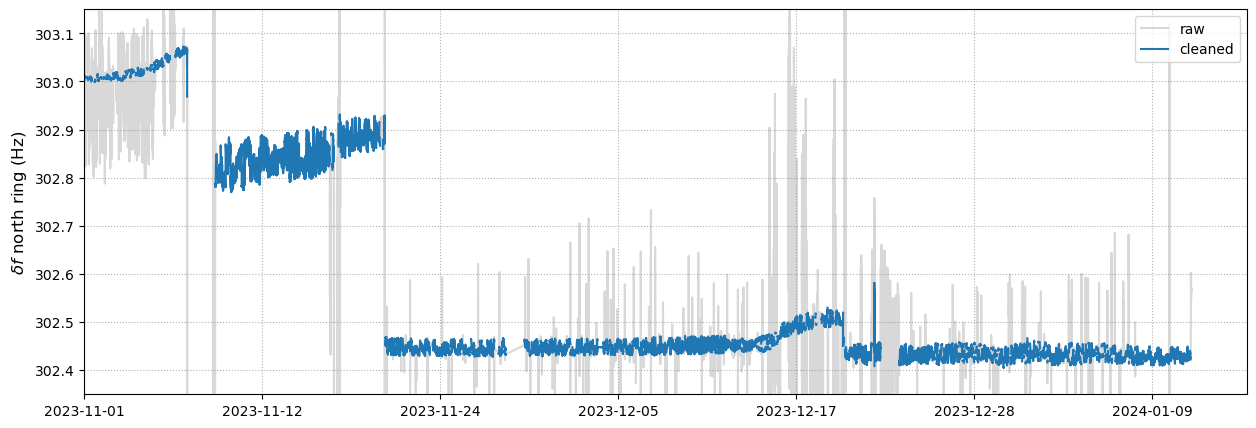

In [24]:
def __makeplot():

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    # time_scaling = 1/86400
    time_scaling = 1

    ax.plot(bs.time_sec*time_scaling, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax.plot(bs.time_sec*time_scaling, bs.fj_fs_nan, color="tab:blue", label="cleaned")
    # ax.plot(bs.time_sec*time_scaling, bs.fj_fs_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax.set_ylim(302.35, 303.15)
    ax.ticklabel_format(useOffset=False)
    ax.set_ylabel("$\delta f$ north ring (Hz)", fontsize=font)

    ax.grid(ls=":", zorder=0)
    ax.legend(loc=1)
    ax.set_xlim(left=0)


    ## add dates to x-axis
    ref_date = str(bs.time1.iloc[0])[:10]
    tcks = ax.get_xticks()
    tcklbls = [UTCDateTime(UTCDateTime(ref_date)+t).date for t in tcks]
    ax.set_xticklabels(tcklbls)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"SF_BS_RU_longterm_cleaned.png", format="png", dpi=150, bbox_inches='tight')


## Load WROMY Data

In [17]:
from andbro__load_WROMY_stream import __load_wromy_stream

ws1 = __load_wromy_stream(config['path_to_sds'], "BW.WROMY..WS1", config['tbeg'], config['tend'])
ws5 = __load_wromy_stream(config['path_to_sds'], "BW.WROMY..WS5", config['tbeg'], config['tend'])
ws9 = __load_wromy_stream(config['path_to_sds'], "BW.WROMY..WS9", config['tbeg'], config['tend'])

Specified end: 2024-01-12T00:00:00.000000Z 
Trace end:     2024-01-11T23:59:59.000000Z
File: BW.WROMY.WS5.D.2024.001, does not exists!
File: BW.WROMY.WS5.D.2024.002, does not exists!
File: BW.WROMY.WS5.D.2024.003, does not exists!
File: BW.WROMY.WS5.D.2024.004, does not exists!
File: BW.WROMY.WS5.D.2024.005, does not exists!
Specified end: 2024-01-12T00:00:00.000000Z 
Trace end:     2024-01-07T05:36:44.000000Z
File: BW.WROMY.WS9.D.2024.001, does not exists!
File: BW.WROMY.WS9.D.2024.002, does not exists!
File: BW.WROMY.WS9.D.2024.003, does not exists!
File: BW.WROMY.WS9.D.2024.004, does not exists!
File: BW.WROMY.WS9.D.2024.005, does not exists!
Specified end: 2024-01-12T00:00:00.000000Z 
Trace end:     2024-01-07T05:43:32.000000Z


In [18]:
# plt.plot(bs[bs.time1 < "2023-11-20 14:00"].fj_fs)
# plt.ylim(302, 303)

/tmp/ipykernel_1751552/3986233301.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[Nrow-1].set_xticklabels(tcklbls)


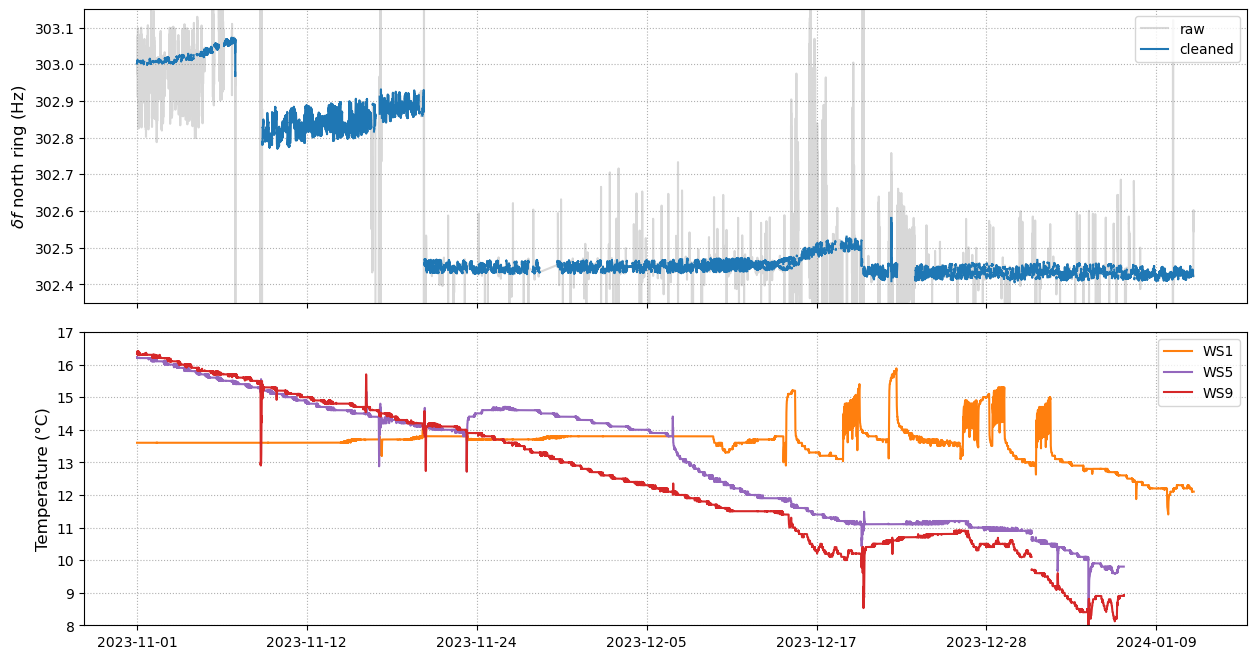

In [25]:
def __makeplot():

    Nrow, Ncol = 2, 1

    font = 12

    ref_date = str(bs.time1.iloc[0])[:10]

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    # time_scaling = 1/86400
    time_scaling = 1

    ax[0].plot(bs.time_sec*time_scaling, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax[0].plot(bs.time_sec*time_scaling, bs.fj_fs_nan, color="tab:blue", label="cleaned")
    # ax[0].plot(bs.time_sec*time_scaling, bs.fj_fs_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax[0].set_ylim(302.35, 303.15)
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\delta f$ north ring (Hz)", fontsize=font)

    ax[1].plot(ws1.select(channel="*T")[0].times(reftime=UTCDateTime(ref_date)),
               __smooth(ws1.select(channel="*T")[0].data, 600), color="tab:orange", label="WS1")
    ax[1].plot(ws5.select(channel="*T")[0].times(reftime=UTCDateTime(ref_date)),
               __smooth(ws5.select(channel="*T")[0].data, 600), color="tab:purple", label="WS5")
    ax[1].plot(ws9.select(channel="*T")[0].times(reftime=UTCDateTime(ref_date)),
               __smooth(ws9.select(channel="*T")[0].data, 600), color="tab:red", label="WS9")

    ax[1].set_ylim(8, 17)
    ax[1].set_ylabel("Temperature (°C)", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)
        # ax[_n].set_xlim(left=0)

    # ax[2].set_xlabel("Time (days)", fontsize=font)

    ## add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [UTCDateTime(UTCDateTime(ref_date)+t).date for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    gc.collect()

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"SF_BS_RU_multiday_Case3_temperature.png", format="png", dpi=150, bbox_inches='tight')


## Load Rain Data

In [26]:
from andbro__load_FURT_stream import __load_furt_stream

In [27]:
def __cumsum_rain(arr, n_samples):

    from numpy import cumsum, zeros, nansum, nanmean

    arr_out = zeros(len(arr))
    for i, dat in enumerate(arr):
        arr_out[i] = nansum(arr[i:i+n_samples])
        # arr_out[i] = nanmean(arr[i:i+n_samples])

    return arr_out

In [ ]:
furt = __load_furt_stream(config['tbeg'], config['tend'], path_to_archive=bay_path+'gif_online/FURT/WETTER/')

/home/andbro/andbro_python/andbro__load_FURT_stream.py:105: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df0 = read_csv(path_to_archive+filename, header=0, usecols=[0,1,5,8,10,12,13,14], names=['date', 'time', 'Dm', 'Sm', 'T', 'H', 'P','Rc'])


In [ ]:
rain = furt.select(channel="LAR")

In [ ]:
# rain_cumsum = __cumsum_rain(rain[0].data, 3600)
rain_smooth = __smooth(__interpolate_nan(rain[0].data), 3600)


### Compute PSD

In [ ]:
from functions.multitaper_psd import __multitaper_psd

dat1 = np.array((bs.fj_fs_inter - bs.fj_fs_inter.mean()).replace(np.nan, 0))
dat2 = np.array((bs.w_s_inter - bs.w_s_inter.mean()).replace(np.nan, 0))

# dat1 = np.array((bs.fj_fs - bs.fj_fs.mean()).replace(np.nan, 0))
# dat2 = np.array((bs.w_s - bs.w_s.mean()).replace(np.nan, 0))

dat1 = dat1 - np.mean(dat1)
dat2 = dat2 - np.mean(dat2)

# f1, psd1 = __multitaper_psd(dat1, 60, n_win=10)
# f2, psd2 = __multitaper_psd(dat2, 60, n_win=10)

# f1, psd1 = __welch_psd(dat1, 60, twin_sec=86400)
# f2, psd2 = __welch_psd(dat2, 60, twin_sec=86400)

f1, psd1, pha1 = __get_fft(dat1, 60)
f2, psd2, pha2 = __get_fft(dat2, 60)


In [ ]:
def __makeplot():

    Nrow, Ncol = 2, 1

    font = 12

    time_scaling = 1/86400

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8))

    ax[0].plot(bs.time_sec*time_scaling, bs.fj_fs_inter, color="black", label=f"$\delta$f w/ backscatter")
    ax[0].plot(bs.time_sec*time_scaling, bs.w_s_inter, color="tab:red", label=f"$\delta$f w/o backscatter")

    ax[0].ticklabel_format(useOffset=False)

    ax[1].semilogx(f1, psd1, color="black", label=f"$\delta$f w/ backscatter")
    ax[1].semilogx(f2, psd2, color="tab:red", label=f"$\delta$f w/o backscatter")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1, fontsize=font-1)

    ax[0].set_ylim(302.40, 302.53)
    ax[1].set_ylim(0, max(psd1))
    ax[0].set_xlim(0, max(bs.time_sec)*time_scaling)

    ax[0].set_ylabel(f"$\delta$f (Hz)", fontsize=font)
    ax[0].set_xlabel(f"Time from {config['tbeg'].date} {config['tbeg'].time} UTC (hours)", fontsize=font)

    # ax[1].set_ylabel("PSD (Hz$^2$ /Hz)", fontsize=font)
    ax[1].set_ylabel("Spectrum (Hz $\sqrt{Hz}$)", fontsize=font)
    ax[1].set_xlabel("Frequency (Hz)", fontsize=font)

    ax[1].axvline(1/(12*3600), ls="--", color="grey", zorder=0)
    ax[1].axvline(1/(24*3600), ls="--", color="grey", zorder=0)

    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"SagnacFrequency_BS_RU_multiday_Case2_PSD.png", format="png", dpi=200, bbox_inches='tight')


### Convert beat to tilt

$\delta$ f = S * $\Omega_E$ * sin($\phi_{lat}$ + $\theta_{dip}$ + $\epsilon_{tilt}$)

$\epsilon_{tilt}$ = arcsin( $\delta$ f / S / $\Omega_E$ ) - $\phi_{lat}$ - $\theta_{dip}$

In [ ]:
from functions.sagnac_to_tilt import __sagnac_to_tilt

In [ ]:
# def __to_tilt(data):

#     from numpy import pi, sqrt, arccos, deg2rad, arcsin

#     dip = 109.5
#     L = 12.0
#     S = (np.sqrt(3)*L)/(3*632.8e-9)
#     lat = 48.162941
#     omegaE = 2*np.pi/86400

#     return arcsin(data /omegaE /S) - deg2rad(lat) - deg2rad(dip)

In [ ]:
def __conversion_to_tilt(st, conf):

    st0 = st.copy()

    def convertTemp(trace):
        Tvolt = trace.data * conf.get('gainTemp')
        coeff = conf.get('calcTempCoefficients')
        return coeff[0] + coeff[1]*Tvolt + coeff[2]*Tvolt**2 + coeff[3]*Tvolt**3

    def convertTilt(trace, conversion, sensitivity):
        return trace.data * conversion * sensitivity

    for tr in st0:
        if tr.stats.channel[-1] == 'T':
            tr.data = convertTemp(tr)
        elif tr.stats.channel[-1] == 'N':
            tr.data = convertTilt(tr, conf['convTN'], conf['gainTilt'])
        elif tr.stats.channel[-1] == 'E':
            tr.data = convertTilt(tr, conf['convTE'], conf['gainTilt'])
        else:
            print("no match")

    print(f"  -> converted data of {st[0].stats.station}")
    return st0

In [ ]:
fs_tilt = __sagnac_to_tilt(bs.w_s_inter, "U")

plt.plot(fs_tilt)

### Load Tilt Data

In [ ]:
tromy0 = __read_sds(config['path_to_sds'], "BW.TROMY..MAN", config['tbeg']-600, config['tend']+600)
tromy0 += __read_sds(config['path_to_sds'], "BW.TROMY..MAE", config['tbeg']-600, config['tend']+600)
tromy0 += __read_sds(config['path_to_sds'], "BW.TROMY..MAT", config['tbeg']-600, config['tend']+600)

## tiltmeter configurations
confTilt = __readYaml(root_path+"Documents/ROMY/tiltmeter/", "tiltmeter.conf")

tromy0 = __conversion_to_tilt(tromy0, confTilt['TROMY'])

tromy0 = tromy0.trim(bs.time1[0], bs.time1[bs.time1.size-1]);

tromy = tromy0.copy();

tromy = tromy.merge();

tromy.plot(equal_scale=False);

### LowPass Version

In [ ]:
tromy_lp = tromy0.copy()
tromy_lp = tromy_lp.detrend("simple")
tromy_lp = tromy_lp.taper(0.1)
# tromy_lp = tromy_lp.filter("lowpass", freq=0.01, corners=4, zerophase=True)
tromy_lp = tromy_lp.filter("bandpass", freqmin=1/(10*86400), freqmax=1/(1*3600), corners=4, zerophase=True)
tromy_lp = tromy_lp.resample(1/(1*3600), no_filter=True)

tromy_lp.merge()
tromy_lp.plot(equal_scale=False);

In [ ]:
gc.collect()

In [ ]:
from obspy.signal.cross_correlation import correlate, xcorr_max

arr1 = np.nan_to_num(tromy_lp.select(channel="*T")[0].data, 0)
arr2 = np.nan_to_num(tromy_lp.select(channel="*N")[0].data, 0)

# arr1 = __interpolate_nan(tromy_lp.select(channel="*T")[0].data)
# arr2 = __interpolate_nan(tromy_lp.select(channel="*N")[0].data)

Nshift = len(arr1)
ccf = correlate(arr1, arr2, shift=Nshift, demean=True, normalize='naive', method='fft')
cclags = np.arange(-Nshift, Nshift+1)

shift, value = xcorr_max(ccf)
print("Nshift: ", shift, "Tshift: ", shift*tromy_lp[0].stats.delta, "CC: ", value)

cclag = shift

plt.plot(cclags, ccf)

In [ ]:
arr1 = np.nan_to_num(tromy_lp.select(channel="*N")[0].data, 0)
arr2 = np.nan_to_num(tromy_lp.select(channel="*T")[0].data, 0)


fig, ax = plt.subplots(4, 1, figsize=(15, 8))

ax[0].plot(arr1, label="tilt")
ax[0].plot(-arr2*1e-5, label="-1 temperature")
correct = np.roll(arr2, -cclag)
ax[0].plot(-correct*1e-5, label="shifted -1 temperature")

ax[0].legend()

ax[1].plot(arr1, label="tilt")
ax[1].plot(arr1 + arr2*1e-5, label="tilt corrected")
ax[1].plot(arr1 + correct*1.2e-5, label="tilt corrected")

ax[1].legend()

ax[2].scatter(arr2, arr1, s=1)
ax[2].scatter(correct, arr1, s=1)

plt.show();

In [ ]:
from scipy import signal

# tf = signal.TransferFunction(arr1, arr2, dt=0.2)

# plt.plot(tf)

In [ ]:
def __correct_temperature_trend(st, correction, n_shift=0, intercept=False):

    from numpy import roll

    st0 = st.copy()
    if roll == 0:
        temperature = st0.select(channel="*T")[0].data
    else:
        temperature = roll(st0.select(channel="*T")[0].data, n_shift)


    if intercept:
        st0.select(channel="*N")[0].data -= (correction['N_slope']* temperature + correction['N_intercept'])
        st0.select(channel="*E")[0].data -= (correction['E_slope']* temperature + correction['N_intercept'])
    else:
        st0.select(channel="*N")[0].data -= (correction['N_slope']* temperature)
        st0.select(channel="*E")[0].data -= (correction['E_slope']* temperature)

    plt.plot(temperature)

    return st0

In [ ]:
## correction for temperature trends based on MAT
temperature_correction = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/","tiltmeter_temperature_correction.yml")

# from functions.correct_temperature_trend import __correct_temperature_trend

tromy_mod = __correct_temperature_trend(tromy, temperature_correction['TROMY'], n_shift=0, intercept=False)

tromy_mod.plot(equal_scale=False);

#### BROMY Data

In [ ]:
# bromy = __read_sds(config['path_to_sds'], "BW.DROMY..LAN", config['tbeg']-600, config['tend']+600)
# bromy += __read_sds(config['path_to_sds'], "BW.DROMY..LAT", config['tbeg']-600, config['tend']+600)

# ## tiltmeter configurations
# confTilt = __readYaml(root_path+"Documents/ROMY/tiltmeter/", "tiltmeter.conf")

# bromy = __conversion_to_tilt(bromy, confTilt['BROMY'])

# bromy2 = bromy.copy()
# bromy2= bromy2.decimate(6, no_filter=False)
# bromy2= bromy2.decimate(10, no_filter=False)

# temp_gradient = np.gradient(bromy2[0].data, 60)[10:-10]

# bromy.trim(config['tbeg'], config['tend'])
# bromy2.trim(config['tbeg'], config['tend'])

# bromy2.trim(bs.time1[0], bs.time1[bs.time1.size-1])
# bromy2.plot(equal_scale=False);


In [ ]:
# plt.plot(rain_cumsum/np.nanmax(rain_cumsum))
# plt.plot(rain_smooth/np.nanmax(rain_smooth))

### Load WROMY data

In [ ]:
from andbro__load_WROMY_stream import __load_wromy_stream

ws1 = __load_wromy_stream(config['path_to_sds'], "BW.WROMY..WS1", config['tbeg'], config['tend'])
ws5 = __load_wromy_stream(config['path_to_sds'], "BW.WROMY..WS5", config['tbeg'], config['tend'])
ws9 = __load_wromy_stream(config['path_to_sds'], "BW.WROMY..WS9", config['tbeg'], config['tend'])

In [ ]:
# ws1 = ws1.decimate(6, no_filter=False)
# ws1 = ws1.decimate(10, no_filter=False)

# ws5 = ws5.decimate(6, no_filter=False)
# ws5 = ws5.decimate(10, no_filter=False)

# ws9 = ws9.decimate(6, no_filter=False)
# ws9 = ws9.decimate(10, no_filter=False)

In [ ]:
ws5.plot(equal_scale=False);

In [ ]:
from functions.smoothing import __smooth

ws1_T = ws1.select(channel="*T")[0].data
ws1_T_smooth = __smooth(ws1_T, 60)
ws1_gradient = np.gradient(ws1_T_smooth, 5)

ws5_T = ws5.select(channel="*T")[0].data
ws5_T_smooth = __smooth(ws5_T, 60)
ws5_gradient = np.gradient(ws5_T_smooth, 5)

ws9_T = ws9.select(channel="*T")[0].data
ws9_T_smooth = __smooth(ws9_T, 60)
ws9_gradient = np.gradient(ws9_T_smooth, 5)

In [ ]:
# # plt.plot(ws1_gradient)
# # plt.plot(ws5_gradient)
# plt.plot(ws1_gradient-ws5_gradient)

# plt.ylim(-0.01, 0.01)

## Plotting

### CWT

In [ ]:
from functions.compute_cwt import __compute_cwt

In [ ]:
def __compute_cwt(times, arr1, tdelta, datalabel="dat1", log=False, period=False, tscale='sec', fmax=None, normalize=True, plot=True):

    from pycwt import wct, xwt, Morlet, ar1, significance, cwt
    from numpy import std, nanmean, nan, nansum, nanmax, nanmin, nanvar, ones, nan_to_num, polyfit, polyval, array, reshape, nanpercentile
    import matplotlib.pyplot as plt
    from numpy import sum as npsum

    times = array(times, dtype='float64')
    arr1 = array(arr1, dtype='float64')

    if len(arr1) != len(arr1):
        print(" -> different lenght of arrays!")
        return

    def __mask_cone(arr2d, ff, thresholds, fill=nan):
        mask = ones(arr2d.shape)
        for k in range(arr2d.shape[0]):  ##85
            for l in range(arr2d.shape[1]):  ## 1401
                 if ff[k] < thresholds[l]:
                    mask[k,l] = fill
        return mask


    ## specify parameters
    N = len(arr1)
    dt = tdelta
    df = 1/dt
    significance_threshold = 0.95

    ## detrend data
    p = polyfit(times - times[0], arr1, 1)
    dat_notrend = arr1 - polyval(p, times - times[0])
    std = dat_notrend.std()  # Standard deviation
    var = std ** 2  # Variance
    arr1 = dat_notrend / std  # Normalized dataset

    ## create mother wavelet
    mother_wavelet = Morlet(6)
    s0_set = 2 * dt  # Starting scale
    dj_set = 1 / 12  # Twelve sub-octaves per octaves
    J_set = int(7 / dj_set)  # Seven powers of two with dj sub-octaves
    #print(s0_set, dj_set, J_set)


    cwt, scales, ff_cwt, cone_p, fft, fftfreqs = cwt(
                                                        arr1,
                                                        dt=dt,
                                                        dj=dj_set, #0.05,
                                                        s0=s0_set, #-1,
                                                        J=J_set, #-1,
                                                        wavelet=mother_wavelet,  # u'morlet',
                                                    )

    cone_f = 1/cone_p
    print(ff_cwt[0])
    pp_cwt = 1/ff_cwt

    if tscale == "min":
        times /= 60
        cone_p /= 60
        pp_cwt /= 60
        unit = "min"
    elif tscale == "hour":
        times /= 3600
        cone_p /= 3600
        pp_cwt /= 3600
        unit = "hour"
    else:
        unit = "s"

    ## building cone
    mask_cone = __mask_cone(cwt, ff_cwt, cone_f, fill=nan)


    ## get real part
    cwt_power = abs(cwt)

    ## normalize cross wavelet transform
    if normalize:
        cwt_power /= nanmax(cwt_power.reshape((1, cwt_power.size))[0])

    ## apply masks
    # cwt_power_masked = cwt_power * mask_cwt * mask_cone
    cwt_power_masked = cwt_power * mask_cone

    ## compute global cross wavelet transform power
    global_mean_cwt_f = nanmean(cwt_power_masked, axis=1)
    global_sum_cwt_f = nansum(cwt_power_masked, axis=1)

    # if normalize:
    #     global_sum_cwt_f /= max(global_sum_cwt_f)
    #     global_mean_cwt_f /= max(global_mean_cwt_f)


    ## ____________________________________________________
    ## plotting
    if plot:

        from mpl_toolkits.axes_grid1 import make_axes_locatable

        import matplotlib.pyplot as plt
        from matplotlib.gridspec import GridSpec

        Ncol, Nrow = 4, 3

        font = 12

        fig = plt.figure(figsize=(15, 8))

        gs = GridSpec(Nrow, Ncol, figure=fig)

        ax1 = fig.add_subplot(gs[0, :-1])
        ax2 = fig.add_subplot(gs[1:, :-1])
        ax3 = fig.add_subplot(gs[1:, 3:])

        ax1.set_xticklabels([])
        ax3.set_yticklabels([])

        plt.subplots_adjust(hspace=0.1, wspace=0.1)


        ax1.plot(times, arr1, alpha=1, color="black", lw=1, label=datalabel)

        ax1.set_xlim(min(times), max(times))
        ax1.set_ylabel("Amplitude", fontsize=font)
        ax1.legend(loc=1)



        if period:
            ca2 = ax2.pcolormesh(
                                times,
                                pp_cwt,
                                cwt_power,
                                # vmin=min(reshape(cwt_power, cwt_power.size)),
                                # vmax=max(reshape(cwt_power, cwt_power.size)),
                                vmin=nanpercentile(reshape(cwt_power, cwt_power.size), 2),
                                vmax=nanpercentile(reshape(cwt_power, cwt_power.size), 98),
                                )

            ax3.plot(global_mean_cwt_f, pp_cwt, color="black", label="global mean power")

            ax33 = ax3.twiny()
            ax33.plot(global_sum_cwt_f, pp_cwt, color="darkred", label="global sum power")

        else:
            ca2 = ax2.pcolormesh(
                                times,
                                ff_cwt,
                                cwt_power,
                                # vmin=min(reshape(cwt_power, cwt_power.size)),
                                # vmax=max(reshape(cwt_power, cwt_power.size)),
                                vmin=nanpercentile(reshape(cwt_power, cwt_power.size), 2),
                                vmax=nanpercentile(reshape(cwt_power, cwt_power.size), 98),
                                )


            ax3.plot(global_mean_cwt_f, ff_cwt, color="black", label="global mean power")

            ax33 = ax3.twiny()
            ax33.plot(global_sum_cwt_f, ff_cwt, color="darkred", label="global sum power")

        if period:
            ax2.plot(times, cone_p, color="white", ls="--")
            ax2.fill_between(times, cone_p, max(pp_cwt), color="white", alpha=0.2)
            ax2.set_ylabel(f"Period ({unit})", fontsize=font)
        else:
            ax2.plot(times, cone_f, color="white")
            ax2.fill_between(times, cone_f, min(ff_cwt), color="white", alpha=0.2)
            ax2.set_ylabel("Frequency (Hz)", fontsize=font)
            ax3.set_xlabel("Frequency (Hz)", fontsize=font)

        # ax3.legend()
        ax3.set_xlabel("global mean power", fontsize=font)
        ax33.set_xlabel("global sum power", fontsize=font, color="darkred")
        ax33.tick_params(axis='x', labelcolor="darkred")
        ax2.set_xlabel(f"Time ({unit})", fontsize=font)


        ## add colorbar
        cbar_ax = fig.add_axes([0.73, 0.75, 0.17, 0.08]) #[left, bottom, width, height]
        cb = plt.colorbar(ca2, cax=cbar_ax, orientation="horizontal", extend="both")
        cb.set_label("CWT power", fontsize=font, color="black")



        if fmax:
            if period:
                ax3.set_xlim(0, 1/(fmax*2))
            else:
                if fmax*2 <= 1/tdelta/2:
                    ax3.set_xlim(0, fmax*2)
                    ax2.set_ylim(0, fmax)
        else:
            if period:
                ax2.set_ylim(min(pp_cwt), max(pp_cwt))
            else:
                ax2.set_ylim(min(ff_cwt), max(ff_cwt))



        plt.show();

    ## prepare dict for return
    out = {}
    out['times'] = times
    out['frequencies'] = ff_cwt
    out['cwt_power'] = cwt_power
    out['cone_mask'] = mask_cone
    out['global_mean_cwt'] = global_mean_cwt_f
    out['global_sum_cwt'] = global_sum_cwt_f


    if plot:
        out['fig'] = fig

    return out

In [ ]:
ttt = np.array(bs.time_sec)
arr = np.array(bs.w_s)
dt = 60 # seconds

out = __compute_cwt(ttt, arr, dt, tscale="hour", datalabel="$\delta$f (Hz)",
                    log=False, period=True, fmax=None, plot=True)

out['fig'].savefig(config['path_to_figs']+f"SagnacFrequency_BS_RU_multiday_Case2_CWT.png", format="png", dpi=200, bbox_inches='tight')


## FFT

In [ ]:
def __makeplot():

    Nrow, Ncol = 2, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8))

    ax[0].plot(bs.time_sec/3600, bs.fj_fs, color="black", label=f"$\delta$f w/ backscatter")
    ax[0].plot(bs.time_sec/3600, bs.w_s, color="tab:red", label=f"$\delta$f w/o backscatter")

    ax[0].ticklabel_format(useOffset=False)

    ax[1].semilogx(f1, psd1, color="black", label=f"$\delta$f w/ backscatter")
    ax[1].semilogx(f2, psd2, color="tab:red", label=f"$\delta$f w/o backscatter")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1, fontsize=font-1)

    ax[0].set_ylim(302.41, 302.52)
    ax[1].set_ylim(0, max(psd1))

    ax[0].set_ylabel(f"$\delta$f (Hz)", fontsize=font)
    ax[0].set_xlabel(f"Time from {config['tbeg'].date} {config['tbeg'].time} UTC (hours)", fontsize=font)

    # ax[1].set_ylabel("PSD (Hz$^2$ /Hz)", fontsize=font)
    ax[1].set_ylabel("Spectrum (Hz $\sqrt{Hz}$)", fontsize=font)
    ax[1].set_xlabel("Frequency (Hz)", fontsize=font)

    ax[1].axvline(1/(12*3600), ls="--", color="grey", zorder=0)
    ax[1].axvline(1/(24*3600), ls="--", color="grey", zorder=0)

    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"SagnacFrequency_BS_RU_multiday_Case2_PSD.png", format="png", dpi=200, bbox_inches='tight')


## Tilt

In [ ]:
def __reduce(dat, n_samples):
    return dat - np.nanmean(dat[:n_samples])

In [ ]:
def __makeplot():

    dat = np.array(bs.w_s)

    tr = Trace()
    tr.data = dat
    tr.stats.delta = 60
    tr.stats.starttime = bs.time1[0]

    hr1 = 1
    tr1 = tr.copy()
    tr1 = tr1.detrend("demean")
    tr1 = tr1.taper(0.01)
    tr1 = tr1.filter("lowpass", freq=1/(hr1*3600), corners=2, zerophase=True)

    hr2 = 24
    tr2 = tr.copy()
    tr2.data = __sagnac_to_tilt(__interpolate_nan(dat), "U")
    tr2 = tr2.detrend("simple")
    tr2 = tr2.taper(0.01)
    tr2 = tr2.filter("lowpass", freq=1/(hr2*3600), corners=2, zerophase=True)

    scaling_factor = 0.01

    Nrow, Ncol = 2, 1

    font = 12

    tilt_scaling = 1e6
    time_scaling = 1

    ref_time = config['tbeg']

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax[0].plot(bs.time_sec*time_scaling, bs.fj_fs_inter, color="grey", alpha=0.5, label=f"$\Delta$f w/ backscatter")
    ax[0].plot(bs.time_sec*time_scaling, bs.fj_fs_smooth, color="black", label=f"$\Delta$f w/ backscatter (smoothed)")
    # ax[0].plot(bs.time_sec*time_scaling, tr1.data*1e3, color="black", label=f"$\Delta$f w/o backscatter (lp < {hr1} hour)")
    ax[0].set_ylim(302.41, 302.52)
    ax[0].ticklabel_format(useOffset=False)


    # ax[1].plot(bs.time_sec*time_scaling,
    #            tr2.data*tilt_scaling*scaling_factor,
    #            ls="--", color="k", label=f"{scaling_factor}* N-S tilt by $\Delta$f (lp < {hr2} hour)",
    #            zorder=2,
    #           )

    tromy_tilt = tromy.select(channel="*N")[0].data
    ax[1].plot(tromy.select(channel="*N")[0].times(reftime=ref_time)*time_scaling,
               __reduce(__smooth(tromy_tilt, 600), 600)*tilt_scaling,
               color="tab:orange", label=f"N-S tilt",
               zorder=2,
              )

    tromy_tilt = tromy.select(channel="*E")[0].data
    ax[1].plot(tromy.select(channel="*E")[0].times(reftime=ref_time)*time_scaling,
               __reduce(__smooth(tromy_tilt, 600), 600)*tilt_scaling,
               color="tab:purple", label=f"E-W tilt",
               zorder=2,
              )

    ax11 = ax[1].twinx()
    ax11.fill_between(rain[0].times(reftime=ref_time)*time_scaling, rain_smooth, alpha=0.6, zorder=1)
    ax11.set_ylim(bottom=0)
    ax11.set_yticks(np.linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ax[1].get_yticks())))
    ax11.tick_params(axis="y", colors="tab:blue")
    ax11.set_ylabel("Cumulative Rain (mm/hour)", fontsize=font, color="tab:blue")

    ax12 = ax[1].twinx()
    p12 = ax12.plot(tromy.select(channel="*T")[0].times(reftime=ref_time)*time_scaling,
                    tromy.select(channel="*T")[0].data, alpha=0.6, zorder=1, color="darkred", ls="--")

    # ax12.set_ylim(bottom=0)
    # ax12.set_yticks(np.linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ax[1].get_yticks())))
    # ax12.tick_params(axis="y", colors="tab:blue")
    ax12.set_ylabel("Temperature (°C)", fontsize=font, color="darkred")
    ax12.tick_params(axis='y', colors="darkred")
    ax12.spines.right.set_position(("axes", 1.10))

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)

    ax[0].legend(loc=1, fontsize=font-1)
    ax[1].legend(loc=1, fontsize=font-1, ncol=1)

    ax[0].set_ylabel(f"$\Delta$f (mHz)", fontsize=font)

    ax[1].set_ylabel("Tilt ($\mu$rad)", fontsize=font)
    ax[1].set_xlabel(f"Time (days) from {config['tbeg'].date} {config['tbeg'].time} UTC", fontsize=font)

    ## add dates to x-axis
    ref_date = UTCDateTime(config['tbeg'])
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [str(UTCDateTime(ref_date+t).date) for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    gc.collect();
    return fig


fig = __makeplot();

fig.savefig(config['path_to_figs']+f"SagnacFrequency_BS_RU_multiday_Case3_Tilt_Rain_example.png", format="png", dpi=150, bbox_inches='tight')


In [ ]:
def __makeplot():


    f11 = 1/(14*3600)
    f12 = 1/(10*3600)

    f21 = 1/(26*3600)
    f22 = 1/(22*3600)

    detrend="demean"
    taper = 0.1
    corners = 4

    tr = Trace()
    tr.data = __sagnac_to_tilt(np.array(bs.fj_fs_inter), "U")
    tr.stats.delta = 60
    tr.stats.starttime = bs.time1[0]

    tr1 = tr.copy()
    tr1 = tr1.detrend(detrend).detrend("simple")
    tr1 = tr1.taper(taper)
    tr1 = tr1.filter("bandpass", freqmin=f11, freqmax=f12, corners=corners, zerophase=True)

    tr2 = tr.copy()
    tr2 = tr2.detrend(detrend).detrend("simple")
    tr2 = tr2.taper(taper)
    tr2 = tr2.filter("bandpass", freqmin=f21, freqmax=f22, corners=corners, zerophase=True)


    tromy1 = tromy.select(channel="*N").copy();
    tromy1 = tromy1.split()
    tromy1 = tromy1.detrend(detrend).detrend("simple")
    tromy1 = tromy1.taper(taper)
    tromy1 = tromy1.filter("bandpass", freqmin=f11, freqmax=f12, corners=corners, zerophase=True)
    tromy1 = tromy1.merge()


    tromy2 = tromy.select(channel="*N").copy();
    tromy2 = tromy2.split()
    tromy2 = tromy2.detrend(detrend).detrend("simple")
    tromy2 = tromy2.taper(taper)
    tromy2 = tromy2.filter("bandpass", freqmin=f21, freqmax=f22, corners=corners, zerophase=True)
    tromy2 = tromy2.merge()


    Nrow, Ncol = 2, 1

    font = 12

    scaling = 1e9

    ref_time = config['tbeg']

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax[0].plot(tromy1[0].times(reftime=ref_time), -tromy1[0].data*scaling, color="black", label="-1* N-S Tilt")
    ax[1].plot(tromy2[0].times(reftime=ref_time), -tromy2[0].data*scaling, color="black", label="-1* N-S Tilt")

    ax0 = ax[0].twinx()
    ax0.plot(tr1.times(reftime=ref_time), tr1.data*scaling, color="darkred", label="$\Delta $f  to Tilt")

    ax1 = ax[1].twinx()
    ax1.plot(tr2.times(reftime=ref_time), tr2.data*scaling, color="darkred", label="$\Delta $f  to Tilt")

    ax[0].set_ylabel("Tilt (nrad)", fontsize=font)
    ax[1].set_ylabel("Tilt (nrad)", fontsize=font)
    # ax[1].set_xlabel(f"Time (days) from {config['tbeg'].date} {config['tbeg'].time} UTC", fontsize=font)

    ax0.set_ylabel("Tilt (nrad)", fontsize=font, color="darkred")
    ax1.set_ylabel("Tilt (nrad)", fontsize=font, color="darkred")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    ax0.legend(loc=4)
    ax1.legend(loc=4)

    ax[0].text(.01, .97, '(a) 11-13 h', ha='left', va='top', transform=ax[0].transAxes, fontsize=font+2)
    ax[1].text(.01, .97, '(b) 23-25 h', ha='left', va='top', transform=ax[1].transAxes, fontsize=font+2)

    ax[0].set_ylim(-40, 40)
    ax[1].set_ylim(-15, 15)

    ax0.tick_params(axis='y', colors='darkred')
    ax0.set_yticks(np.linspace(ax0.get_yticks()[0], ax0.get_yticks()[-1], len(ax[0].get_yticks())))

    ax1.tick_params(axis='y', colors='darkred')
    ax1.set_yticks(np.linspace(ax1.get_yticks()[0], ax1.get_yticks()[-1], len(ax[1].get_yticks())))

    ## add dates to x-axis
    ref_date = UTCDateTime(config['tbeg'])
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [str(UTCDateTime(ref_date+t).date) for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"SagnacFrequency_BS_RU_multiday_Case3_Tilt_Tides.png", format="png", dpi=150, bbox_inches='tight')


## Testing

In [ ]:
dat = __to_tilt(np.array(bs.w_s))

f1 = 1/(13*3600)
f2 = 1/(11*3600)

f1 = 1/(25*3600)
f2 = 1/(23*3600)


print(f1, f2)

tr = Trace()
tr.data = dat
tr.stats.delta = 60
tr.stats.starttime = bs.time1[0]
tr.plot();
print(tr)

tr.plot();

tr = tr.detrend("demean").detrend("linear")
tr.plot();

tr = tr.taper(0.1)
tr.plot();

# tr.filter("lowpass", freq=f2, corners=2, zerophase=True)
tr = tr.filter("bandpass", freqmin=f1, freqmax=f2, corners=2, zerophase=True)
tr.plot();

fs_tilt_lp = tr.data

In [ ]:
def __makeplot():

    Nrow, Ncol = 1, 1

    font = 14

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8))

    ax.plot(bs.time_sec/3600, bs.w_s, color="black", zorder=4, label=f"$\delta$f w/o backscatter")

    ax.ticklabel_format(useOffset=False)

    ax00 = ax.twinx()

    p2, = ax00.plot(bromy2[0].times()/3600, bromy2[0].data, color="tab:blue", label=f"", zorder=2)
    ax00.set_ylim(13.31, 13.325)

    # p2, = ax00.plot(bromy2[0].times()/3600, temp_gradient, color="tab:blue", label=f"", zorder=2)
    # ax00.set_ylim(-0.001, 0.001)

    # p2, = ax00.plot(ws1.select(channel="*T")[0].times()/3600, ws1_gradient, color="tab:blue", label=f"", zorder=2)
    # ax00.set_ylim(-0.01, 0.01)

    ax00.set_ylabel("Temperature Change (°C/s)", fontsize=font, color=p2.get_color())
    ax00.tick_params(axis='y', colors=p2.get_color())

    ax.grid(ls=":", zorder=1)
    ax.legend(loc=1, fontsize=font-1)

    # ax.set_ylim(302.97, 303.07)


    # ax.set_xlim(0, 108)
    # ax.set_xlim(30, 70)

    ax.set_ylabel(f"$\delta$f (Hz)", fontsize=font)
    ax.set_xlabel(f"Time from {config['tbeg'].date} {config['big-pumptbeg'].time} UTC (hours)", fontsize=font)

    plt.show();
    return fig

# fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"SagnacFrequency_BS_RU_multiday_TemperatureChange_zoomin.png", format="png", dpi=200, bbox_inches='tight')
